In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
81001,Animals thrown into volcano in Indonesia's Kas...,A picture gallery shows live animals being thr...
26989,England reach World Cup semi-finals for 1st ti...,England defeated Sweden in the quarters on Sat...
71648,Faced no govt interference as RBI Chief: Raghu...,Raghuram Rajan on Tuesday said that he had no ...
93283,Court summons Snapdeal Founders for allegedly ...,A Delhi court has summoned Snapdeal Founders K...
97725,"Lalu, Sushil Modi engage in Twitter banter ove...","Taking a dig at Lalu Prasad Yadav, BJP leader ..."
36165,GM directed $2.1-billion fraud: Arrested PNB D...,Former PNB Deputy Manager Gokulnath Shetty has...
80128,Mumbai man stabs neighbour after marriage prop...,A 27-year-old man was arrested in Bhandup by t...
82322,HC gives Maha govt 2 weeks to explain Sanjay's...,The Bombay High Court has given two weeks to t...
47250,Dalit woman live 14 yrs less than upper-caste ...,An average Dalit woman lives 14.6 years less t...
92473,75-tonne Ramses II statue unveiled in Egypt,Egyptian authorities have unveiled a 75-tonne ...


# 1. 데이터 전처리 

>## 1) 데이터 정리 (null, 반복, 텍스트정규화, 불용어제거)

In [3]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [4]:
# 반복 제거 

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [5]:
# null 제거

print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


In [6]:
# 텍스트 정규화(text normalization)를 위한 사전 확인

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
# NLTK(function name :  stopwords)의 영어(english)불용어 사전 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 확인한 정규화, 불용화 사전을 참고하여,
# 소문자변환, 섞여있는 html 제거, 특수문제 제거할 예정.
# text는 불용어를 제거하나, target인 headlines는 자연스런 문장을 위해 제거하지 않음.
# remove_stopwords 추가하면 가능.

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [10]:
# 훈련 데이터 전체에 대해서 text/headlines 나눠 전처리를 수행

# Text : stopword 제거
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
# headlines : stopword 제거 안함

clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
# 정제 후 empty 샘플이 있는지 확인하고, null값으로 대체하여 확인

data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

>## 2) train, test data 나누기

>>### (1) 샘플 최대길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


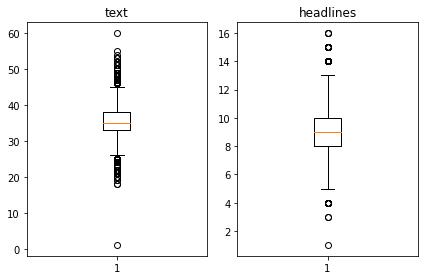

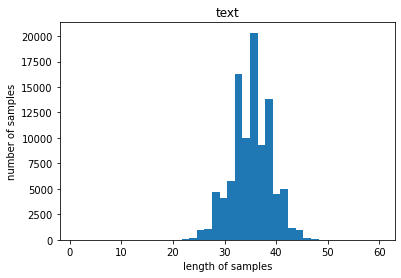

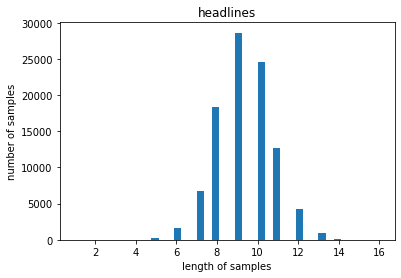

In [13]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
text_max_len = 40
headlines_max_len = 11

In [15]:
# 데이터의 몇프로인지 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [16]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [17]:
# 정해진 길이보다 길면 제외하는 방법으로 정제하기

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


>>### (2) 디코더에 sos, eos토큰 추가해서 decoder_input, output 나누기

In [18]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [19]:
# 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[18302 74048 37825 ... 14950 15530 19707]


In [21]:
# 랜덤으로 뽑은 정수시퀀스에 데이터를 매칭한 후 정수기준으로 샘플 순서를 정의하여 shuffle된 효과내기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [23]:
# train 전체에서 test만큼 슬라이싱

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 집합

encoder_input_train  
decoder_input_train  
decoder_target_train  

encoder_input_test  
decoder_input_test  
decoder_target_test  
모두 다 정수 인코딩 해야함.

>## 3) 정수 인코딩 

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [24]:
# encoder

# 정수로 인덱싱하기 (fit_on_texts())
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
# 각단어의 빈도수 체크 (word_counts.items()) 함수 이용하여
# 7번 미만 단어가 전체에서 차지하는 비율 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64733
등장 빈도가 6번 이하인 희귀 단어의 수: 44148
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20585
단어 집합에서 희귀 단어의 비율: 68.2001452118703
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.782304080164795


7회 미만으로 등장한 단어가 전체의 68%나 되는 44000개이고, 등장빈도도 3.7% 정도이며, 이를 다 제외하면 단어장이 64000 -> 20000으로 줄어듬. 20000은 기다릴 수 없어서 10000으로 줄여보기로 함.

In [26]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 (8216)와 비슷한 숫자만큼
# 단어장 총 단어 갯수를 limit 걸어주기
# num_words()의 값을 정해주면 단어집합의 크기 제어 가능

src_vocab = 10000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [27]:
# texts_to_sequences()로 단어장을 참조하여 주어진 단어를 모두 정수로 변환

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[12, 7169, 1546, 47, 389, 624, 1092, 56, 513, 458, 201, 7, 1, 86, 160, 6399, 421, 1618, 2217, 72, 201, 6399, 7641, 7386, 1482, 47], [37, 522, 9195, 78, 57, 573, 62, 273, 410, 156, 683, 103, 7, 1941, 884, 37, 574, 16, 231, 139, 6, 78, 29, 179, 234, 2875, 1417, 402, 190, 1303, 756, 683, 1040], [5736, 2448, 7170, 2176, 793, 1247, 1437, 692, 810, 1126, 68, 604, 44, 27, 233, 22, 450, 830, 2176, 68, 24, 720, 4567, 635, 679, 810, 24, 527, 10, 461, 250, 2, 14, 32]]


In [28]:
# decoder

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
# 7회 미만

threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28530
등장 빈도가 6번 이하인 희귀 단어의 수: 19646
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8884
단어 집합에서 희귀 단어의 비율: 68.8608482299334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.893481189075274


7회미만인 단어는 전체중 56% 정도 되는 16000개 정도이고, 3.53% 정도의 빈도로 사용되고 있음. 이를 다빼면 단어장 크기가 28000->12000 정도로 줄어듬. 2500정도로 줄여보려함,

In [30]:
# 변환
# decoder의 train,test의 input, target 모두다.

tar_vocab = 2500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9, 2300, 418, 89, 79, 4, 416], [1, 73, 7, 44, 808, 3, 111, 613, 179], [1, 1160, 4, 472, 3, 842, 24, 3, 177, 33], [1, 1135, 230, 6, 15, 1385, 1237, 11, 18, 209, 1979], [1, 1251, 512, 297, 9, 380, 371]]
target
decoder  [[9, 2300, 418, 89, 79, 4, 416, 2], [73, 7, 44, 808, 3, 111, 613, 179, 2], [1160, 4, 472, 3, 842, 24, 3, 177, 33, 2], [1135, 230, 6, 15, 1385, 1237, 11, 18, 209, 1979, 2], [1251, 512, 297, 9, 380, 371, 2]]


>## 4) 최종 데이터셋 6개 정리하기 

>>### (1) 희귀단어제외 후 null값 제거하기

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 5
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 68670
훈련 레이블의 개수 : 68670
테스트 데이터의 개수 : 17167
테스트 레이블의 개수 : 17167


>>### (2) 패딩하기

In [32]:
# 아까 정한 최대 길이로 뒤에 0붙여 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 2. 모델 설계

Batchnormalization 추가, dim 늘렸음

>## 1. Encoder (함수형 API)

In [74]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256 #128(None)
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 (src_vocab=단어장총수=10000, 256)
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)


# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)


# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

>## 2. Decoder

In [75]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)


# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


In [76]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 40, 256)      2560000     input_17[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 40, 256), (N 525312      embedding_10[0][0]               
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

>## 3. Attention 메커니즘

In [77]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 상위와 비교해보기
# # 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# # 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 40, 256)      2560000     input_17[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 40, 256), (N 525312      embedding_10[0][0]               
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

# 3. 모델 훈련

In [78]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 25s 75ms/step - loss: 4.4317 - val_loss: 4.0707
Epoch 2/50
269/269 [==============================] - 19s 72ms/step - loss: 3.8812 - val_loss: 3.7140
Epoch 3/50
269/269 [==============================] - 19s 70ms/step - loss: 3.5625 - val_loss: 3.4653
Epoch 4/50
269/269 [==============================] - 19s 70ms/step - loss: 3.3342 - val_loss: 3.3055
Epoch 5/50
269/269 [==============================] - 19s 70ms/step - loss: 3.1598 - val_loss: 3.1845
Epoch 6/50
269/269 [==============================] - 19s 70ms/step - loss: 3.0207 - val_loss: 3.1005
Epoch 7/50
269/269 [==============================] - 19s 70ms/step - loss: 2.9049 - val_loss: 3.0284
Epoch 8/50
269/269 [==============================] - 19s 70ms/step - loss: 2.8049 - val_loss: 2.9765
Epoch 9/50
269/269 [==============================] - 19s 70ms/step - loss: 2.7179 - val_loss: 2.9348
Epoch 10/50
269/269 [==============================] - 19s 70ms/step - loss: 2.639

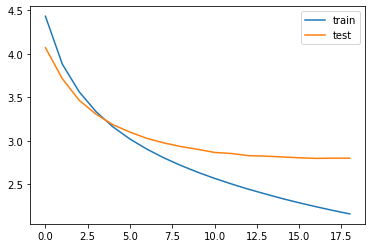

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. 인퍼런스 모델 구현

In [80]:
# 정수 -> 문자로 복원, 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [81]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [82]:
# 어텐션으로 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [83]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
    return decoded_sentence


# 5. 모델 테스트

In [84]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [85]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian army soon deploy built robots capable delivering ammunition intended locations fight terrorism jammu kashmir army proposal requirement robots approved centre robots several surveillance cameras transmission systems range metres 
실제 요약 : army to robots to fight terror in jammu and kashmir 
예측 요약 :  army to launch robot to


원문 : us removed least indian products list items eligible duty free treatment system india largest largest oldest us trade preference programme india duty free exports us programme tune billion 
실제 요약 : us duty free on of indian products 
예측 요약 :  us to give billion to


원문 : pakistan tuesday placed former pm nawaz sharif daughter name exit control list following conviction reference corruption case per reports placed list barred leaving country sharif may return pakistan london later week 
실제 요약 : pak puts ex pm sharif daughter on exit control list 
예측 요약 :  ex pak pm sharif to be in jail


원문 : rashtriya sahara journalist pankaj mishra shot bihar thursd

# 6. 추출적 요약 실행해보기

In [230]:
from summa.summarizer import summarize

df = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
df = df['text']
type(df)
print('원문:\n',df.values.tolist()[10])
# print(data[data['text'].str.contains('two minor cousins')])
print('\n')
print('추론적요약 결과:\n',data['headlines'].loc[10])
print('\n')
print('추상적요약 결과:\n',summarize(text, ratio = 0.5))

원문:
 Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.


추론적요약 결과:
 up cousins fed human excreta for friendship with boys


추상적요약 결과:
 Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


# 회고

역시 nlp는 전처리가 어렵다. 오늘은 단계별로 정말 이해하려고 노력했다.
seq2seq를 다시 한 번 하니까 조금 나은 것 같았다. 일단 전처리에서 내가 임의값을 잡아야 했던 것 정리해두기.
1. max_len
2. 희귀단어 threshold
3. vocab_size
4. model의 dimension은 256으로 늘림
5. 모델에 이미 dropout이 0.4씩 되어있었기 때문에 혹시 과적합을 위해 추가한다면 BatchNormalization을 해도 좋았을 듯.

추상 과 추출의 결과를 비교했는데, 둘 다 만족스럽지 못했다.

문법적으로는 추출이 훨씬 좋았다. 그 이유는 추상에서 수동태를 잡아내지 못했기 때문이다. 내가 고른 원문이 왜 이런내용인지는 모르겠으나,, 원문에 의하면 같은 학교를 다니던 네팔의 두 명의 사촌이 가족으로부터 인분을 먹길 강요받았고, 경찰서로 고문을 피해 도망쳤다는 내용인데, 추상에서는 사촌들이 인분을 먹이줬다라고 했기 때문이다.


하지만 핵심단어는 추상이 훨씬 정확했다. 반면 추출은 ratio 0.5 이하이거나 word를 적은수로 주면 아예 summary가 되지 않았고, 결과값도 두 문장 중 한문장을 그대로 가져왔기 때문에 아주 고차원적이라고 할 수 없을 듯 하다. 

과제수행 실행순서 정리한 것 : https://kolazzing.com/entry/Ex12-%EB%89%B4%EC%8A%A4-%EC%9A%94%EC%95%BD%EB%B4%87


루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
- 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.